# Load file names

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np
import pandas as pd
import os
import librosa
import librosa.display
import IPython
from IPython.display import Audio
from IPython.display import Image
import matplotlib.pyplot as plt

EMOTIONS = {1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 0:'surprise'} # surprise je promenjen sa 8 na 0
DATA_PATH = 'E:/Bhuvan/Dataset/'
SAMPLE_RATE = 48000

data = pd.DataFrame(columns=['Emotion', 'Emotion intensity', 'Gender','Path'])
for dirname, _, filenames in os.walk(DATA_PATH):
    for filename in filenames:
        file_path = os.path.join(dirname, filename)
        identifiers = filename.split('.')[0].split('-')
        emotion = (int(identifiers[2]))
        if emotion == 8: # promeni surprise sa 8 na 0
            emotion = 0
        if int(identifiers[3]) == 1:
            emotion_intensity = 'normal' 
        else:
            emotion_intensity = 'strong'
        if int(identifiers[6])%2 == 0:
            gender = 'female'
        else:
            gender = 'male'
        
        data = data.append({"Emotion": emotion,
                            "Emotion intensity": emotion_intensity,
                            "Gender": gender,
                            "Path": file_path
                             },
                             ignore_index = True
                          )
# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
print("number of files is {}".format(len(data)))
data.head()

number of files is 1440


,Emotion,Emotion intensity,Gender,Path
0,1,normal,male,E:/Bhuvan/Dataset/03-01-01-01-01-01-01.wav
1,1,normal,female,E:/Bhuvan/Dataset/03-01-01-01-01-01-02.wav
2,1,normal,male,E:/Bhuvan/Dataset/03-01-01-01-01-01-03.wav
3,1,normal,female,E:/Bhuvan/Dataset/03-01-01-01-01-01-04.wav
4,1,normal,male,E:/Bhuvan/Dataset/03-01-01-01-01-01-05.wav


Number of examples per emotion

In [3]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(x=range(8), height=data['Emotion'].value_counts())
ax.set_xticks(ticks=range(8))
ax.set_xticklabels([EMOTIONS[i] for i in range(8)],fontsize=10)
ax.set_xlabel('Emotions')
ax.set_ylabel('Number of examples')

Text(0, 0.5, 'Number of examples')

number of examples per gender

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111)
counts = data['Gender'].value_counts()
ax.bar(x=[0,1], height=counts.values)
ax.set_xticks(ticks=[0,1])
ax.set_xticklabels(list(counts.index))
ax.set_xlabel('Gender')
ax.set_ylabel('Number of examples')

Text(0, 0.5, 'Number of examples')

number of examples per emotion intensity

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111)
counts = data['Emotion intensity'].value_counts()
ax.bar(x=[0,1], height=counts.values)
ax.set_xticks(ticks=[0,1])
ax.set_xticklabels(list(counts.index))
ax.set_xlabel('Gender')
ax.set_ylabel('Number of examples')

Text(0, 0.5, 'Number of examples')

# Load the signals

In [6]:
mel_spectrograms = []
signals = []
for i, file_path in enumerate(data.Path):
    audio, sample_rate = librosa.load(file_path, duration=3, offset=0.5, sr=SAMPLE_RATE)
    signal = np.zeros((int(SAMPLE_RATE*3,)))
    signal[:len(audio)] = audio
    signals.append(signal)
    print("\r Processed {}/{} files".format(i,len(data)),end='')
signals = np.stack(signals,axis=0)

 Processed 1439/1440 files

# Split the data

In [7]:
X = signals
train_ind,test_ind,val_ind = [],[],[]
X_train,X_val,X_test = [],[],[]
Y_train,Y_val,Y_test = [],[],[]
for emotion in range(len(EMOTIONS)):
    emotion_ind = list(data.loc[data.Emotion==emotion,'Emotion'].index)
    emotion_ind = np.random.permutation(emotion_ind)
    m = len(emotion_ind)
    ind_train = emotion_ind[:int(0.8*m)]
    ind_val = emotion_ind[int(0.8*m):int(0.9*m)]
    ind_test = emotion_ind[int(0.9*m):]
    X_train.append(X[ind_train,:])
    Y_train.append(np.array([emotion]*len(ind_train),dtype=np.int32))
    X_val.append(X[ind_val,:])
    Y_val.append(np.array([emotion]*len(ind_val),dtype=np.int32))
    X_test.append(X[ind_test,:])
    Y_test.append(np.array([emotion]*len(ind_test),dtype=np.int32))
    train_ind.append(ind_train)
    test_ind.append(ind_test)
    val_ind.append(ind_val)
X_train = np.concatenate(X_train,0)
X_val = np.concatenate(X_val,0)
X_test = np.concatenate(X_test,0)
Y_train = np.concatenate(Y_train,0)
Y_val = np.concatenate(Y_val,0)
Y_test = np.concatenate(Y_test,0)
train_ind = np.concatenate(train_ind,0)
val_ind = np.concatenate(val_ind,0)
test_ind = np.concatenate(test_ind,0)
print(f'X_train:{X_train.shape}, Y_train:{Y_train.shape}')
print(f'X_val:{X_val.shape}, Y_val:{Y_val.shape}')
print(f'X_test:{X_test.shape}, Y_test:{Y_test.shape}')
# check if all are unique
unique, count = np.unique(np.concatenate([train_ind,test_ind,val_ind],0), return_counts=True)
print("Number of unique indexes is {}, out of {}".format(sum(count==1), X.shape[0]))

del X

X_train:(1147, 144000), Y_train:(1147,)
X_val:(143, 144000), Y_val:(143,)
X_test:(150, 144000), Y_test:(150,)
Number of unique indexes is 1440, out of 1440


# Augment signals by adding AWGN

In [8]:
def addAWGN(signal, num_bits=16, augmented_num=2, snr_low=15, snr_high=30): 
    signal_len = len(signal)
    # Generate White Gaussian noise
    noise = np.random.normal(size=(augmented_num, signal_len))
    # Normalize signal and noise
    norm_constant = 2.0**(num_bits-1)
    signal_norm = signal / norm_constant
    noise_norm = noise / norm_constant
    # Compute signal and noise power
    s_power = np.sum(signal_norm ** 2) / signal_len
    n_power = np.sum(noise_norm ** 2, axis=1) / signal_len
    # Random SNR: Uniform [15, 30] in dB
    target_snr = np.random.randint(snr_low, snr_high)
    # Compute K (covariance matrix) for each noise 
    K = np.sqrt((s_power / n_power) * 10 ** (- target_snr / 10))
    K = np.ones((signal_len, augmented_num)) * K  
    # Generate noisy signal
    return signal + K.T * noise

In [9]:
aug_signals = []
aug_labels = []
for i in range(X_train.shape[0]):
    signal = X_train[i,:]
    augmented_signals = addAWGN(signal)
    for j in range(augmented_signals.shape[0]):
        aug_labels.append(data.loc[i,"Emotion"])
        aug_signals.append(augmented_signals[j,:])
        data = data.append(data.iloc[i], ignore_index=True)
    print("\r Processed {}/{} files".format(i,X_train.shape[0]),end='')
aug_signals = np.stack(aug_signals,axis=0)
X_train = np.concatenate([X_train,aug_signals],axis=0)
aug_labels = np.stack(aug_labels,axis=0)
Y_train = np.concatenate([Y_train,aug_labels])
print('')
print(f'X_train:{X_train.shape}, Y_train:{Y_train.shape}')

 Processed 1146/1147 files
X_train:(3441, 144000), Y_train:(3441,)


# Calculate mel spectrograms

In [10]:
def getMELspectrogram(audio, sample_rate):
    mel_spec = librosa.feature.melspectrogram(y=audio,
                                              sr=sample_rate,
                                              n_fft=1024,
                                              win_length = 512,
                                              window='hamming',
                                              hop_length = 256,
                                              n_mels=128,
                                              fmax=sample_rate/2
                                             )
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec_db

# test function
audio, sample_rate = librosa.load(data.loc[0,'Path'], duration=3, offset=0.5,sr=SAMPLE_RATE)
signal = np.zeros((int(SAMPLE_RATE*3,)))
signal[:len(audio)] = audio
mel_spectrogram = getMELspectrogram(signal, SAMPLE_RATE)
librosa.display.specshow(mel_spectrogram, y_axis='mel', x_axis='time')
print('MEL spectrogram shape: ',mel_spectrogram.shape)

MEL spectrogram shape:  (128, 563)


In [11]:
mel_train = []
print("Calculatin mel spectrograms for train set")
for i in range(X_train.shape[0]):
    mel_spectrogram = getMELspectrogram(X_train[i,:], sample_rate=SAMPLE_RATE)
    mel_train.append(mel_spectrogram)
    print("\r Processed {}/{} files".format(i,X_train.shape[0]),end='')
print('')
mel_train = np.stack(mel_train,axis=0)
del X_train
X_train = mel_train

mel_val = []
print("Calculatin mel spectrograms for val set")
for i in range(X_val.shape[0]):
    mel_spectrogram = getMELspectrogram(X_val[i,:], sample_rate=SAMPLE_RATE)
    mel_val.append(mel_spectrogram)
    print("\r Processed {}/{} files".format(i,X_val.shape[0]),end='')
print('')
mel_val = np.stack(mel_val,axis=0)
del X_val
X_val = mel_val

mel_test = []
print("Calculatin mel spectrograms for test set")
for i in range(X_test.shape[0]):
    mel_spectrogram = getMELspectrogram(X_test[i,:], sample_rate=SAMPLE_RATE)
    mel_test.append(mel_spectrogram)
    print("\r Processed {}/{} files".format(i,X_test.shape[0]),end='')
print('')
mel_test = np.stack(mel_test,axis=0)
del X_test
X_test = mel_test

print(f'X_train:{X_train.shape}, Y_train:{Y_train.shape}')
print(f'X_val:{X_val.shape}, Y_val:{Y_val.shape}')
print(f'X_test:{X_test.shape}, Y_test:{Y_test.shape}')

Calculatin mel spectrograms for train set
 Processed 3440/3441 files
Calculatin mel spectrograms for val set
 Processed 142/143 files
Calculatin mel spectrograms for test set
 Processed 149/150 files
X_train:(3441, 128, 563), Y_train:(3441,)
X_val:(143, 128, 563), Y_val:(143,)
X_test:(150, 128, 563), Y_test:(150,)


# Create the model

In [12]:
import torch
import torch.nn as nn

class ParallelModel(nn.Module):
    def __init__(self,num_emotions):
        super().__init__()
        # conv block
        self.conv2Dblock = nn.Sequential(
            # 1. conv block
            nn.Conv2d(in_channels=1,
                       out_channels=16,
                       kernel_size=3,
                       stride=1,
                       padding=1
                      ),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.3),
            # 2. conv block
            nn.Conv2d(in_channels=16,
                       out_channels=32,
                       kernel_size=3,
                       stride=1,
                       padding=1
                      ),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),
            nn.Dropout(p=0.3),
            # 3. conv block
            nn.Conv2d(in_channels=32,
                       out_channels=64,
                       kernel_size=3,
                       stride=1,
                       padding=1
                      ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),
            nn.Dropout(p=0.3),
            # 4. conv block
            nn.Conv2d(in_channels=64,
                       out_channels=64,
                       kernel_size=3,
                       stride=1,
                       padding=1
                      ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),
            nn.Dropout(p=0.3)
        )
        # LSTM block
        self.lstm_maxpool = nn.MaxPool2d(kernel_size=[2,4], stride=[2,4])
        hidden_size = 128
        self.lstm = nn.LSTM(input_size=64,hidden_size=hidden_size,bidirectional=True, batch_first=True)
        self.dropout_lstm = nn.Dropout(0.1)
        self.attention_linear = nn.Linear(2*hidden_size,1) # 2*hidden_size for the 2 outputs of bidir LSTM
        # Linear softmax layer
        self.out_linear = nn.Linear(2*hidden_size+256,num_emotions)
        self.dropout_linear = nn.Dropout(p=0)
        self.out_softmax = nn.Softmax(dim=1)
    def forward(self,x):
        # conv embedding
        conv_embedding = self.conv2Dblock(x) #(b,channel,freq,time)
        conv_embedding = torch.flatten(conv_embedding, start_dim=1) # do not flatten batch dimension
        # lstm embedding
        x_reduced = self.lstm_maxpool(x)
        x_reduced = torch.squeeze(x_reduced,1)
        x_reduced = x_reduced.permute(0,2,1) # (b,t,freq)
        lstm_embedding, (h,c) = self.lstm(x_reduced) # (b, time, hidden_size*2)
        lstm_embedding = self.dropout_lstm(lstm_embedding)
        batch_size,T,_ = lstm_embedding.shape 
        attention_weights = [None]*T
        for t in range(T):
            embedding = lstm_embedding[:,t,:]
            attention_weights[t] = self.attention_linear(embedding)
        attention_weights_norm = nn.functional.softmax(torch.stack(attention_weights,-1),-1)
        attention = torch.bmm(attention_weights_norm,lstm_embedding) # (Bx1xT)*(B,T,hidden_size*2)=(B,1,2*hidden_size)
        attention = torch.squeeze(attention, 1)
        # concatenate
        complete_embedding = torch.cat([conv_embedding, attention], dim=1) 
        
        output_logits = self.out_linear(complete_embedding)
        output_logits = self.dropout_linear(output_logits)
        output_softmax = self.out_softmax(output_logits)
        return output_logits, output_softmax, attention_weights_norm
                                     

In [13]:
def loss_fnc(predictions, targets):
    return nn.CrossEntropyLoss()(input=predictions,target=targets)

# TRAINING

In [14]:
def make_train_step(model, loss_fnc, optimizer):
    def train_step(X,Y):
        # set model to train mode
        model.train()
        # forward pass
        output_logits, output_softmax, attention_weights_norm = model(X)
        predictions = torch.argmax(output_softmax,dim=1)
        accuracy = torch.sum(Y==predictions)/float(len(Y))
        # compute loss
        loss = loss_fnc(output_logits, Y)
        # compute gradients
        loss.backward()
        # update parameters and zero gradients
        optimizer.step()
        optimizer.zero_grad()
        return loss.item(), accuracy*100
    return train_step

In [15]:
def make_validate_fnc(model,loss_fnc):
    def validate(X,Y):
        with torch.no_grad():
            model.eval()
            output_logits, output_softmax, attention_weights_norm = model(X)
            predictions = torch.argmax(output_softmax,dim=1)
            accuracy = torch.sum(Y==predictions)/float(len(Y))
            loss = loss_fnc(output_logits,Y)
        return loss.item(), accuracy*100, predictions
    return validate

scale data

In [16]:
from sklearn.preprocessing import StandardScaler

X_train = np.expand_dims(X_train,1)
X_val = np.expand_dims(X_val,1)
X_test = np.expand_dims(X_test,1)

scaler = StandardScaler()

b,c,h,w = X_train.shape
X_train = np.reshape(X_train, newshape=(b,-1))
X_train = scaler.fit_transform(X_train)
X_train = np.reshape(X_train, newshape=(b,c,h,w))

b,c,h,w = X_test.shape
X_test = np.reshape(X_test, newshape=(b,-1))
X_test = scaler.transform(X_test)
X_test = np.reshape(X_test, newshape=(b,c,h,w))

b,c,h,w = X_val.shape
X_val = np.reshape(X_val, newshape=(b,-1))
X_val = scaler.transform(X_val)
X_val = np.reshape(X_val, newshape=(b,c,h,w))

Train the model

In [17]:
EPOCHS=500
DATASET_SIZE = X_train.shape[0]
BATCH_SIZE = 32
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Selected device is {}'.format(device))
model = ParallelModel(num_emotions=len(EMOTIONS)).to(device)
print('Number of trainable params: ',sum(p.numel() for p in model.parameters()) )
OPTIMIZER = torch.optim.SGD(model.parameters(),lr=0.01, weight_decay=1e-3, momentum=0.8)

train_step = make_train_step(model, loss_fnc, optimizer=OPTIMIZER)
validate = make_validate_fnc(model,loss_fnc)
losses=[]
val_losses = []
acc_ep = []
vala = []
for epoch in range(EPOCHS):
    # schuffle data
    ind = np.random.permutation(DATASET_SIZE)
    X_train = X_train[ind,:,:,:]
    Y_train = Y_train[ind]
    epoch_acc = 0
    epoch_loss = 0
    iters = int(DATASET_SIZE / BATCH_SIZE)
    for i in range(iters):
        batch_start = i * BATCH_SIZE
        batch_end = min(batch_start + BATCH_SIZE, DATASET_SIZE)
        actual_batch_size = batch_end-batch_start
        X = X_train[batch_start:batch_end,:,:,:]
        Y = Y_train[batch_start:batch_end]
        X_tensor = torch.tensor(X,device=device).float()
        Y_tensor = torch.tensor(Y, dtype=torch.long,device=device)
        loss, acc = train_step(X_tensor,Y_tensor)
        epoch_acc += acc*actual_batch_size/DATASET_SIZE
        epoch_loss += loss*actual_batch_size/DATASET_SIZE
        print(f"\r Epoch {epoch}: iteration {i}/{iters}",end='')
    X_val_tensor = torch.tensor(X_val,device=device).float()
    Y_val_tensor = torch.tensor(Y_val,dtype=torch.long,device=device)
    val_loss, val_acc, _ = validate(X_val_tensor,Y_val_tensor)
    losses.append(epoch_loss)
    val_losses.append(val_loss)
    acc_ep.append(epoch_acc)
    vala.append(val_acc)
    print('')
    print(f"Epoch {epoch} --> loss:{epoch_loss:.4f}, acc:{epoch_acc:.2f}%, val_loss:{val_loss:.4f}, val_acc:{val_acc:.2f}%")
    

Selected device is cuda
Number of trainable params:  263593
 Epoch 0: iteration 106/107
Epoch 0 --> loss:2.1285, acc:19.41%, val_loss:2.5408, val_acc:14.69%
 Epoch 1: iteration 106/107
Epoch 1 --> loss:1.9014, acc:24.85%, val_loss:2.3311, val_acc:16.08%
 Epoch 2: iteration 106/107
Epoch 2 --> loss:1.8554, acc:27.06%, val_loss:2.1978, val_acc:20.28%
 Epoch 3: iteration 106/107
Epoch 3 --> loss:1.8409, acc:27.78%, val_loss:2.0493, val_acc:22.38%
 Epoch 4: iteration 106/107
Epoch 4 --> loss:1.7859, acc:29.44%, val_loss:2.1369, val_acc:23.78%
 Epoch 5: iteration 106/107
Epoch 5 --> loss:1.7392, acc:30.19%, val_loss:2.0069, val_acc:28.67%
 Epoch 6: iteration 106/107
Epoch 6 --> loss:1.7224, acc:31.85%, val_loss:2.0134, val_acc:26.57%
 Epoch 7: iteration 106/107
Epoch 7 --> loss:1.6845, acc:33.25%, val_loss:1.8660, val_acc:30.77%
 Epoch 8: iteration 106/107
Epoch 8 --> loss:1.6525, acc:35.08%, val_loss:1.8365, val_acc:29.37%
 Epoch 9: iteration 106/107
Epoch 9 --> loss:1.6439, acc:34.23%, va

# Save model

In [18]:
SAVE_PATH = os.path.join('E:/Bhuvan/MODELS/')
os.makedirs('models',exist_ok=True)
torch.save(model.state_dict(),os.path.join(SAVE_PATH,'cnn_lstm_parallel_model.pt'))
print('Model is saved to {}'.format(os.path.join(SAVE_PATH,'cnn_lstm_parallel_model.pt')))

Model is saved to E:/Bhuvan/MODELS/cnn_lstm_parallel_model.pt


# Load model

In [19]:
LOAD_PATH = os.path.join('E:/Bhuvan/MODELS/')
model = ParallelModel(len(EMOTIONS))
model.load_state_dict(torch.load(os.path.join(LOAD_PATH,'cnn_lstm_parallel_model.pt')))
print('Model is loaded from {}'.format(os.path.join(LOAD_PATH,'cnn_lstm_parallel_model.pt')))

Model is loaded from E:/Bhuvan/MODELS/cnn_lstm_parallel_model.pt


# Test

In [20]:
X_test_tensor = torch.tensor(X_test,device=device).float()
Y_test_tensor = torch.tensor(Y_test,dtype=torch.long,device=device)
test_loss, test_acc, predictions = validate(X_test_tensor,Y_test_tensor)
print(f'Test loss is {test_loss:.3f}')
print(f'Test accuracy is {test_acc:.2f}%')

Test loss is 1.278
Test accuracy is 62.00%


confusion matrix

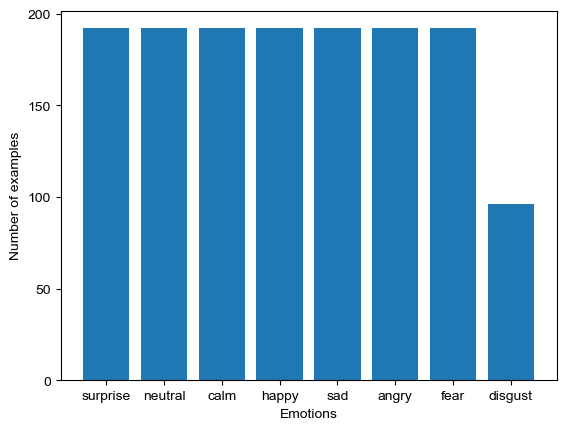

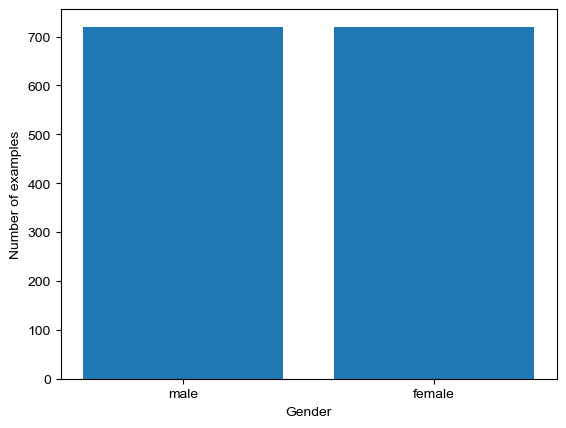

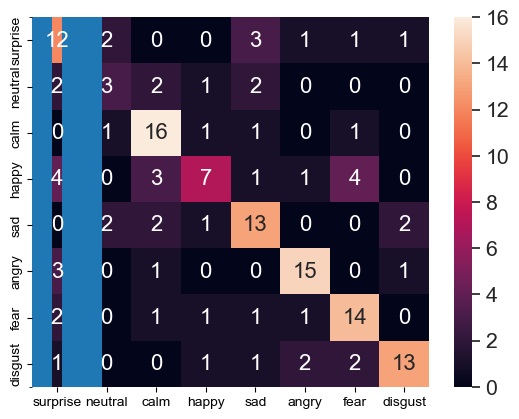

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

predictions = predictions.cpu().numpy()
cm = confusion_matrix(Y_test, predictions)
names = [EMOTIONS[ind] for ind in range(len(EMOTIONS))]
df_cm = pd.DataFrame(cm, index=names, columns=names)
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.show()

correlation between emotion intensity and corectness

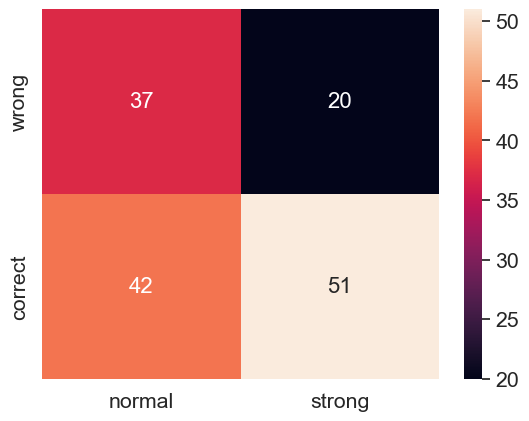

In [22]:
correct_strong = 0
correct_normal = 0
wrong_strong = 0
wrong_normal = 0
for i in range(len(X_test)):
    intensity = data.loc[test_ind[i],'Emotion intensity']
    if Y_test[i] == predictions[i]: # correct prediction
        if  intensity == 'normal':
            correct_normal += 1
        else:
            correct_strong += 1
    else: # wrong prediction
        if intensity == 'normal':
            wrong_normal += 1
        else:
            wrong_strong += 1
array = np.array([[wrong_normal,wrong_strong],[correct_normal,correct_strong]])
df = pd.DataFrame(array,['wrong','correct'],['normal','strong'])
sn.set(font_scale=1.4) # for label size
sn.heatmap(df, annot=True, annot_kws={"size": 16}) # font size
plt.show()

correlation between gender and corectness

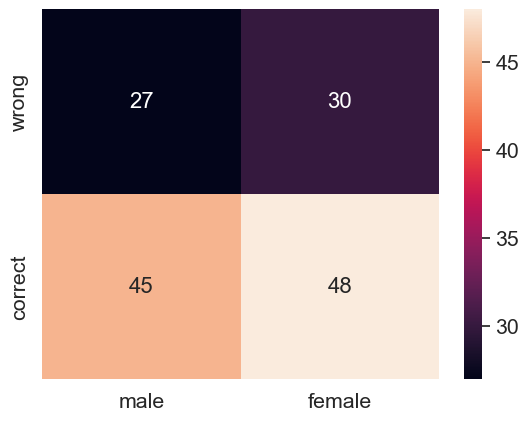

In [23]:
correct_male = 0
correct_female = 0
wrong_male = 0
wrong_female = 0
for i in range(len(X_test)):
    gender = data.loc[test_ind[i],'Gender']
    if Y_test[i] == predictions[i]: # correct prediction
        if  gender == 'male':
            correct_male += 1
        else:
            correct_female += 1
    else: # wrong prediction
        if gender == 'male':
            wrong_male += 1
        else:
            wrong_female += 1
array = np.array([[wrong_male,wrong_female],[correct_male,correct_female]])
df = pd.DataFrame(array,['wrong','correct'],['male','female'])
sn.set(font_scale=1.4) # for label size
sn.heatmap(df, annot=True, annot_kws={"size": 16}) # font size
plt.show()

# Plot loss

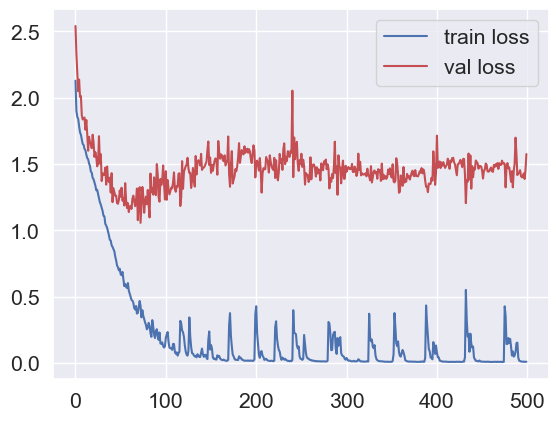

In [24]:
plt.plot(losses,'b')
plt.plot(val_losses,'r')
plt.legend(['train loss','val loss'])
plt.show()

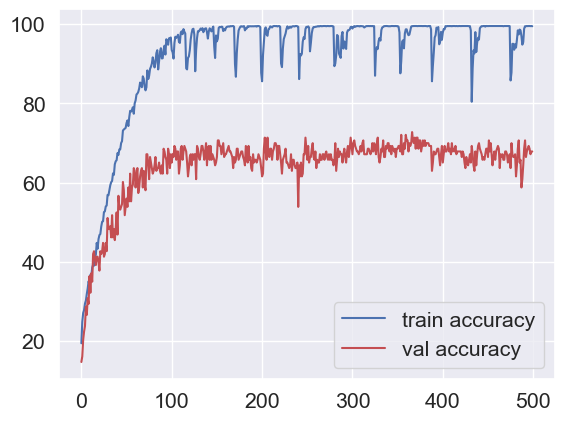

In [25]:
plt.plot(acc_ep,'b')
plt.plot(vala,'r')
plt.legend(['train accuracy','val accuracy'])
plt.show()